# HR-PIcontrol: Exploring relationship between AMOC and GOM SSH

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import dask
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
import os
%matplotlib inline

from mypyutils import calendar_utils as cal
from mypyutils import stat_utils as stat
from mypyutils import mapplot_utils as maps
from mypyutils import colorbar_utils as cbars
from mypyutils import io_utils as io
from mypyutils import regrid_utils as regrid

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2023.7.0'

## Create Dask Cluster

In [89]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
client.shutdown()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        account='NCGD0011',
        walltime='02:00:00',
        local_directory='/glade/scratch/yeager/',
        log_directory='/glade/scratch/yeager/',
        interface='ext',
        job_script_prologue=[
        f'export ESMFMKFILE={os.environ["ESMFMKFILE"]}'])

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        "distributed.scheduler.worker-saturation": "1.0",
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46155 instead
  warnings.warn(


In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeager/proxy/46155/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeager/proxy/46155/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.100:40325,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yeager/proxy/46155/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Main Processing

In [6]:
# N. Atlantic domain for HR
i0 = 0; i1 = 1350
j0 = 1150; j1 = 2310

#### Get HR-PIcontrol SSH

In [7]:
fdir = '/glade/campaign/collections/cmip/CMIP6/CESM-HR/PIcntl/HR/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/tseries/month_1/'
fin = fdir+'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.SSH.002101.050112.nc'
ds_ssh = cal.time_set_midmonth(xr.open_dataset(fin).isel(nlat=slice(j0,j1)).isel(nlon=slice(i0,i1)),'time')

In [ ]:
#%%time
#tmp = ds_ssh['SSH'].chunk({'time':12})
#sshann = tmp.groupby('time.year').mean('time').rename({'year':'time'})
#sshann = dask.optimize(sshann)[0]
#sshann = sshann.load()

Task exception was never retrieved
future: <Task finished name='Task-290357' coro=<Client._gather.<locals>.wait() done, defined at /glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/distributed/client.py:2212> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/distributed/client.py", line 2221, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-290334' coro=<Client._gather.<locals>.wait() done, defined at /glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/distributed/client.py:2212> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/distributed/client.py", line 2221, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-290359' coro=<Client.

In [8]:
%%time
tmp = ds_ssh['SSH']
sshann = tmp.groupby('time.year').mean('time').rename({'year':'time'})

CPU times: user 5min 24s, sys: 30.9 s, total: 5min 55s
Wall time: 7min 42s


#### Get HR-PIcontrol MOC

In [9]:
fdir = '/glade/campaign/collections/cmip/CMIP6/CESM-HR/PIcntl/HR/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/tseries/month_1/'
fin = fdir+'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.MOC.002101.050112.nc'
ds_moc = cal.time_set_midmonth(xr.open_dataset(fin), 'time')

In [10]:
%%time
mocann = ds_moc['MOC'].groupby('time.year').mean('time').rename({'year':'time'}).load()

CPU times: user 1.96 s, sys: 425 ms, total: 2.39 s
Wall time: 2.63 s


In [11]:
moc26 = mocann.sel(lat_aux_grid=26.5,method='nearest').max('moc_z').isel(transport_reg=1,moc_comp=0)
moc45 = mocann.sel(lat_aux_grid=45,method='nearest').max('moc_z').isel(transport_reg=1,moc_comp=0)

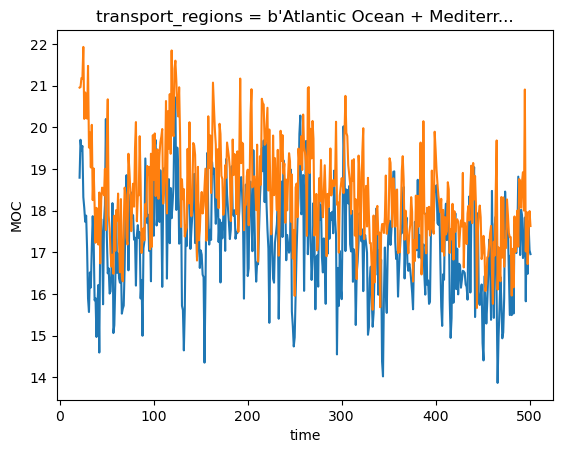

In [12]:
moc45.plot()
moc26.plot()

#### Subsample Years & Detrend

In [13]:
moc26 = moc26.sel(time=slice(100,None))
moc45 = moc45.sel(time=slice(100,None))
sshann = sshann.sel(time=slice(100,None))

In [14]:
def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

In [15]:
moc26dt = detrend_linear(moc26,'time')
moc45dt = detrend_linear(moc45,'time')
sshanndt = detrend_linear(sshann,'time')

In [16]:
del sshann

In [17]:
del tmp

#### Low-Pass Filter

In [18]:
from scipy import signal
def lpf_anndata(dat, period=10):
    fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
    nyquist = fs / 2          # 0.5 times the sampling frequency
    cutoff = fs/period            # cutoff frequency
    cutoff = cutoff/nyquist   # as fraction of nyquist  
    print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
    filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
    filtb, filta = signal.butter(4, cutoff, 'lowpass')
    dat_out = xr.apply_ufunc(signal.sosfiltfilt, filtsos,dat.fillna(0),kwargs={'padtype':'even','axis':0}).where(dat.notnull())
    return dat_out

In [19]:
moc26dtlp = lpf_anndata(moc26dt)
moc45dtlp = lpf_anndata(moc45dt)

cutoff=  10.0  years
cutoff=  10.0  years


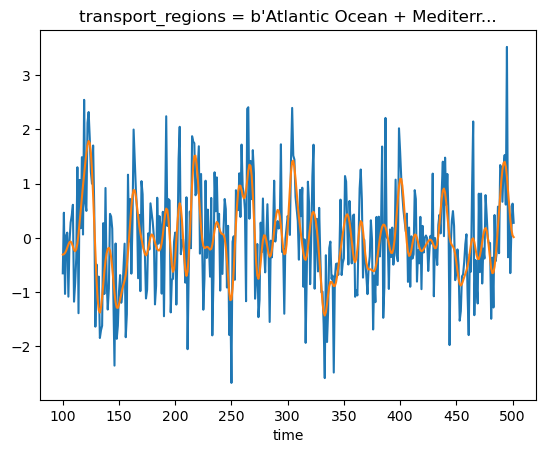

In [20]:
moc26dt.plot()
moc26dtlp.plot()

#### Get HR-FOSI Grid Info

In [21]:
%%time
# get POP grid
infile='/glade/work/fredc/metric/grid/POP_tx0.1v3_grid.nc'
dsg = xr.open_dataset(infile).isel(nlat=slice(j0,j1)).isel(nlon=slice(i0,i1))
hr_htn = dsg.HTN
hr_hte = dsg.HTE
hr_tarea = dsg.TAREA
hr_dzt = dsg.DZT
hr_dzu = dsg.DZU
hr_dxt = dsg.DXT
hr_dyt = dsg.DYT
hr_dxu = dsg.DXU
hr_dyu = dsg.DYU
hr_ht = dsg.HT
hr_lat = dsg.TLAT.fillna(0)
hr_lon = dsg.TLONG.fillna(0)
hr_kmt = dsg.KMT
hr_rmask = dsg.REGION_MASK

CPU times: user 131 ms, sys: 16.7 ms, total: 147 ms
Wall time: 821 ms


In [22]:
hr_lon = xr.where(hr_lon>180.,hr_lon-360,hr_lon)

In [23]:
natl_mask = (hr_lat>=0) & (hr_lat<=70) & ((hr_lon>=-100) & (hr_lon<=20)) & (hr_rmask != 2)

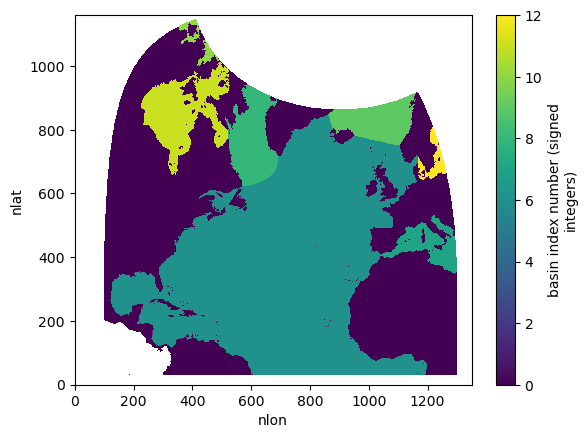

In [24]:
hr_rmask.where(natl_mask).plot()

#### Create GoM Mask

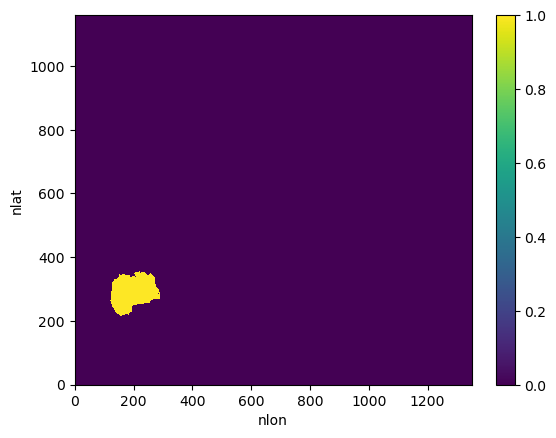

In [25]:
## GoM mask
lons1 = [-87,-84.6,-81,-81]
lats1 = [21.6,22,23.2,25.1]
slp1 = (lats1[1]-lats1[0])/(lons1[1]-lons1[0])
hr_gom = (hr_rmask==6) & (hr_lon<-81) 
hr_gom_fix1 = (hr_rmask==6) & (hr_lon>=-89) & (hr_lon<=-84) & ((hr_lat-lats1[0])>((hr_lon-lons1[0])*slp1))
fix1 = (hr_rmask==6) & (hr_lon>=-89) & (hr_lon<=-84)
hr_gom = xr.where(fix1, hr_gom_fix1,hr_gom)
slp2 = (23-22.5)/(-81-(-84))
hr_gom_fix3 = (hr_rmask==6) & (hr_lon>=-84) & (hr_lon<=-81) & ((hr_lat-(22.5))>((hr_lon-(-84))*slp2))
fix3 = (hr_rmask==6) & (hr_lon>=-84) & (hr_lon<=-81)
hr_gom = xr.where(fix3, hr_gom_fix3,hr_gom)
fix2 = (hr_rmask==6) & (hr_lon>=-82) & (hr_lat>=29)
hr_gom = xr.where(fix2, 0,hr_gom)
hr_gom.plot()

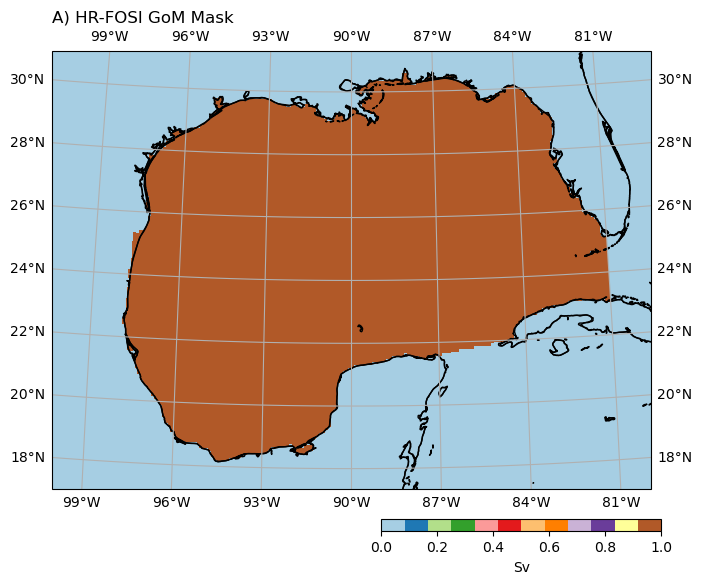

In [26]:
from matplotlib.colors import BoundaryNorm
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.Paired)
overclr = 'gold'
underclr = 'cyan'
lineclr = 'yellow'
lineclr2 = 'orange'
clevs = [-1,0,1]
norm = BoundaryNorm(clevs, ncolors=colmap.N, clip=False)

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(8, 6))
ax2 = fig.add_subplot(1, 1, 1, projection=proj2)

#cntr2 = ax2.contourf(hr_lon, hr_lat, hr_gom, levels=[-1,0,1], cmap=colmap, transform=ccrs.PlateCarree())
cntr2 = ax2.pcolormesh(hr_lon, hr_lat, hr_gom, shading='nearest', cmap=colmap, rasterized=True, transform=ccrs.PlateCarree())
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('A) HR-FOSI GoM Mask',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,-80, 17, 31]
ax2.set_extent(extent,crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label='Sv')

#### Create GOM-average annual SSH timeseries

In [27]:
POP_GOMarea = xr.where(hr_gom,hr_tarea,0)

In [28]:
%%time
GOMssh = sshanndt.weighted(POP_GOMarea).mean(("nlon", "nlat")).load()

CPU times: user 3.45 s, sys: 1.07 s, total: 4.52 s
Wall time: 4.8 s


In [29]:
GOMsshdtlp = lpf_anndata(GOMssh)

cutoff=  10.0  years


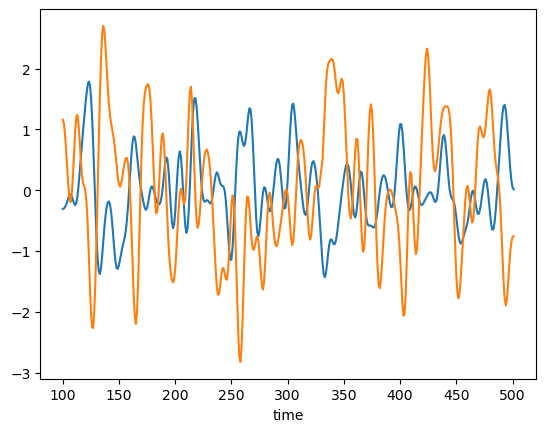

In [30]:
moc26dtlp.plot()
GOMsshdtlp.plot()

## Lead-lag correlation plots

In [31]:
import xskillscore as xs

In [32]:
def lag_regress(x, y, lags):
    corr_list = []; pval_list = []; slp_list = []
    lagcoord = xr.DataArray(lags,dims='lag',name='lag')
    for i in lags:
        xsh = x.shift(time = i)
        corr_list.append(xs.pearson_r(xsh,y,dim='time',skipna=True))
        pval_list.append(xs.pearson_r_eff_p_value(xsh,y,dim='time',skipna=True))
        slp_list.append(xs.linslope(xsh,y,dim='time',skipna=True))
    corr = xr.concat(corr_list,lagcoord)
    pval = xr.concat(pval_list,lagcoord)
    slp = xr.concat(slp_list,lagcoord)
    return xr.Dataset({'corr':corr,'pval':pval,'slp':slp})

In [33]:
%%time
lags = np.arange(-20,21,1)
x,y = xr.align(moc26dtlp, GOMsshdtlp)
moc26_reg_moc26 = lag_regress(x,x,lags)
gom_reg_moc26 = lag_regress(x,y,lags)
x,y = xr.align(moc45dtlp, GOMsshdtlp)
moc45_reg_moc45 = lag_regress(x,x,lags)
gom_reg_moc45 = lag_regress(x,y,lags)

/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:408: RuntimeWarning: divide by zero encountered in scalar divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:408: RuntimeWarning: divide by zero encountered in scalar divide
  t_squared = r ** 2 * (dof / ((1.0 - r) * (1.0 + r)))


CPU times: user 1.27 s, sys: 24.3 ms, total: 1.29 s
Wall time: 1.43 s


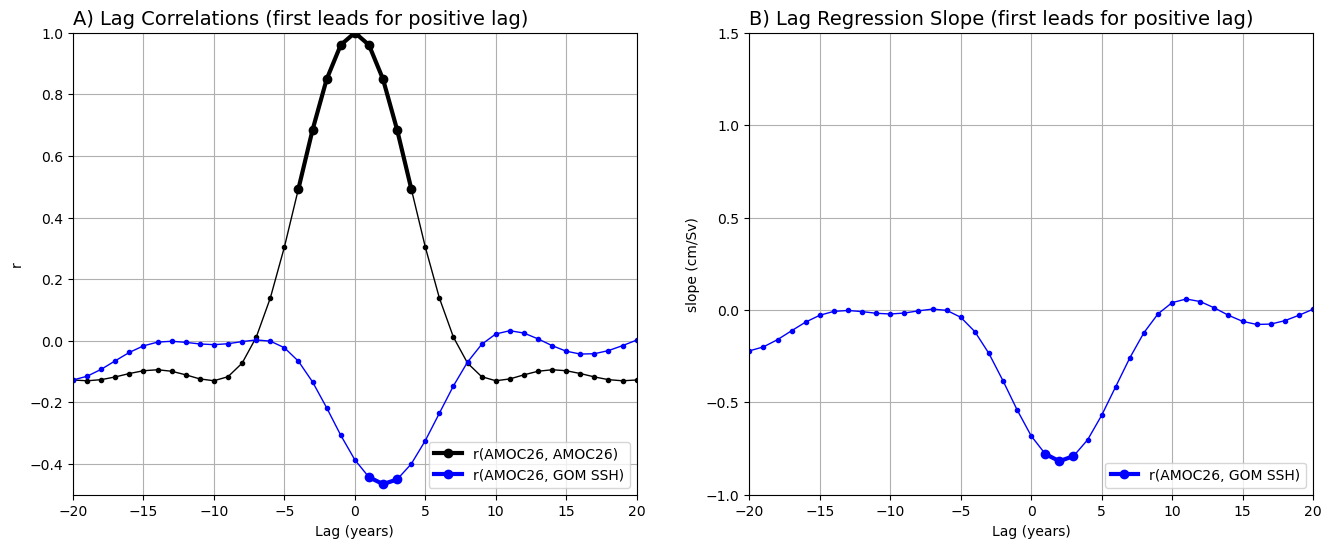

In [34]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fsize=14

sig = 1
ylim = [-1.5,1.]
xlim = [200,2000]
legloc = 'upper left'
siglvl = 0.1

ax1.set_xlabel('Lag (years)')
ax1.set_ylabel('r')
ax1.set_ylim([-0.5,1])
ax1.set_xlim([-20,20])
ax1.set_title(r'A) Lag Correlations (first leads for positive lag)', fontdict={'size':fsize},loc='left')
tmp1 = moc26_reg_moc26
plt2a = ax1.plot(tmp1.lag, tmp1.corr,color='k',marker='.',linewidth=1)
tmp2 = tmp1.where(tmp1.pval < siglvl)
plt2b = ax1.plot(tmp2.lag,tmp2.corr, color='k', marker='o',linewidth=3,label='r(AMOC26, AMOC26)')
tmp1 = gom_reg_moc26
plt2c = ax1.plot(tmp1.lag, tmp1.corr,color='b',marker='.',linewidth=1)
tmp2 = tmp1.where(tmp1.pval < siglvl)
plt2d = ax1.plot(tmp2.lag,tmp2.corr, color='b', marker='o',linewidth=3,label='r(AMOC26, GOM SSH)')
ax1.grid()
ax1.legend(loc='lower right')

ax2.set_xlabel('Lag (years)')
ax2.set_ylabel('slope (cm/Sv)')
ax2.set_ylim([-1.,1.5])
ax2.set_xlim([-20,20])
ax2.set_title(r'B) Lag Regression Slope (first leads for positive lag)', fontdict={'size':fsize},loc='left')
tmp1 = gom_reg_moc26
plt2c = ax2.plot(tmp1.lag, tmp1.slp,color='b',marker='.',linewidth=1)
tmp2 = tmp1.where(tmp1.pval < siglvl)
plt2d = ax2.plot(tmp2.lag,tmp2.slp, color='b', marker='o',linewidth=3,label='r(AMOC26, GOM SSH)')
ax2.grid()
ax2.legend(loc='lower right')

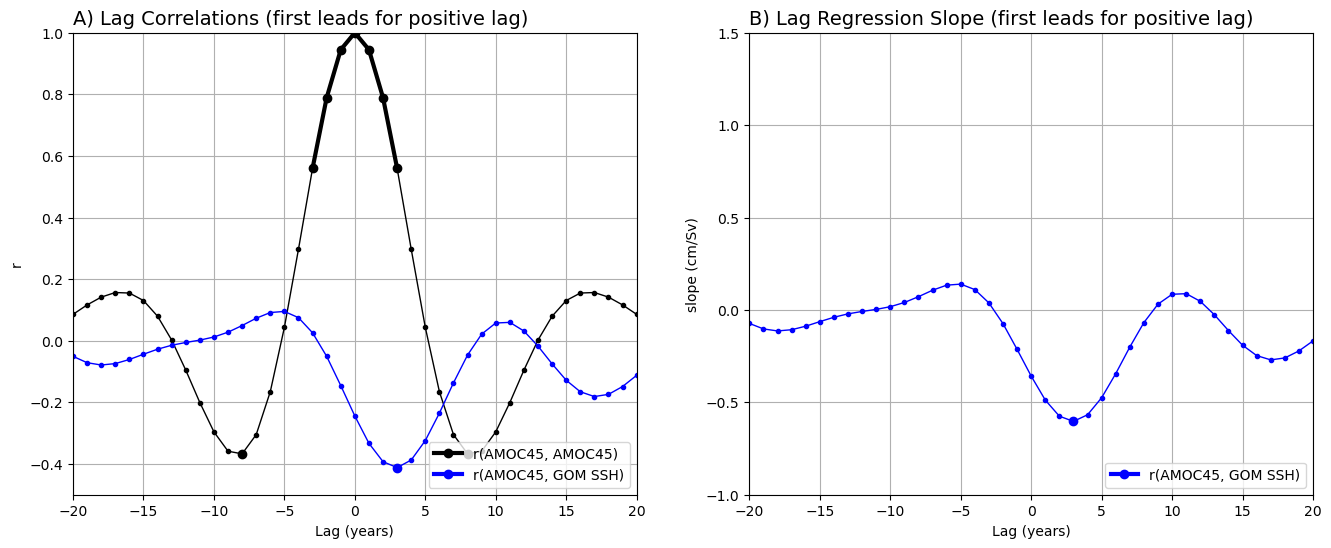

In [35]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fsize=14

sig = 1
ylim = [-1.5,1.]
xlim = [200,2000]
legloc = 'upper left'
siglvl = 0.1

ax1.set_xlabel('Lag (years)')
ax1.set_ylabel('r')
ax1.set_ylim([-0.5,1])
ax1.set_xlim([-20,20])
ax1.set_title(r'A) Lag Correlations (first leads for positive lag)', fontdict={'size':fsize},loc='left')
tmp1 = moc45_reg_moc45
plt2a = ax1.plot(tmp1.lag, tmp1.corr,color='k',marker='.',linewidth=1)
tmp2 = tmp1.where(tmp1.pval < siglvl)
plt2b = ax1.plot(tmp2.lag,tmp2.corr, color='k', marker='o',linewidth=3,label='r(AMOC45, AMOC45)')
tmp1 = gom_reg_moc45
plt2c = ax1.plot(tmp1.lag, tmp1.corr,color='b',marker='.',linewidth=1)
tmp2 = tmp1.where(tmp1.pval < siglvl)
plt2d = ax1.plot(tmp2.lag,tmp2.corr, color='b', marker='o',linewidth=3,label='r(AMOC45, GOM SSH)')
ax1.grid()
ax1.legend(loc='lower right')

ax2.set_xlabel('Lag (years)')
ax2.set_ylabel('slope (cm/Sv)')
ax2.set_ylim([-1.,1.5])
ax2.set_xlim([-20,20])
ax2.set_title(r'B) Lag Regression Slope (first leads for positive lag)', fontdict={'size':fsize},loc='left')
tmp1 = gom_reg_moc45
plt2c = ax2.plot(tmp1.lag, tmp1.slp,color='b',marker='.',linewidth=1)
tmp2 = tmp1.where(tmp1.pval < siglvl)
plt2d = ax2.plot(tmp2.lag,tmp2.slp, color='b', marker='o',linewidth=3,label='r(AMOC45, GOM SSH)')
ax2.grid()
ax2.legend(loc='lower right')

### Spatial correlation/regressions maps

In [36]:
def lag_regress(x, y, lagx=0, lagy=0):
    x,y = xr.align(x,y)
    if lagx!=0:
        if lagx>0: x = x.shift(time = -lagx).isel(time=slice(0,-lagx))
        if lagx<0: x = x.shift(time = -lagx).isel(time=slice(-lagx,None))
    if lagy!=0:
        if lagy>0: y = y.shift(time = -lagy).isel(time=slice(0,-lagy))
        if lagy<0: y = y.shift(time = -lagy).isel(time=slice(-lagy,None))       
    x,y = xr.align(x,y)
    corr = xs.pearson_r(x,y,dim='time',skipna=True)
    slope = xs.linslope(x,y,dim='time',skipna=True)
    neff = xs.effective_sample_size(x,y,dim='time',skipna=True)
    pval = xs.pearson_r_eff_p_value(x,y,dim='time')
    stats = xr.DataArray(['corr','slope','pval','neff'],dims="stat",name="stat")
    xrout = xr.concat([corr,slope,pval,neff],dim=stats)
    return xrout

def concat_regress(x, y, lagyrange):
    """ y is a field being regressed onto x, with y lagging by lagyrange 
    """
    results = []
    lag = xr.DataArray([i for i in lagyrange],dims='lag',name='lag')
    for i in lagyrange:
        result = lag_regress(x,y,lagy=i)
        results.append(result)
    return xr.concat(results,dim=lag)

In [37]:
lagrange = range(-10,6,1)
lag = xr.DataArray([i for i in lagrange],dims='lag',name='lag')
lag

<xarray.DataArray 'lag' (lag: 16)>
array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5])
Dimensions without coordinates: lag

In [38]:
sshanndtlp = lpf_anndata(sshanndt)

cutoff=  10.0  years


In [ ]:
%%time
x,y = xr.align(moc26dtlp, sshanndtlp)
ssh_reg_moc26 = concat_regress(x,y,lagrange)

/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xs

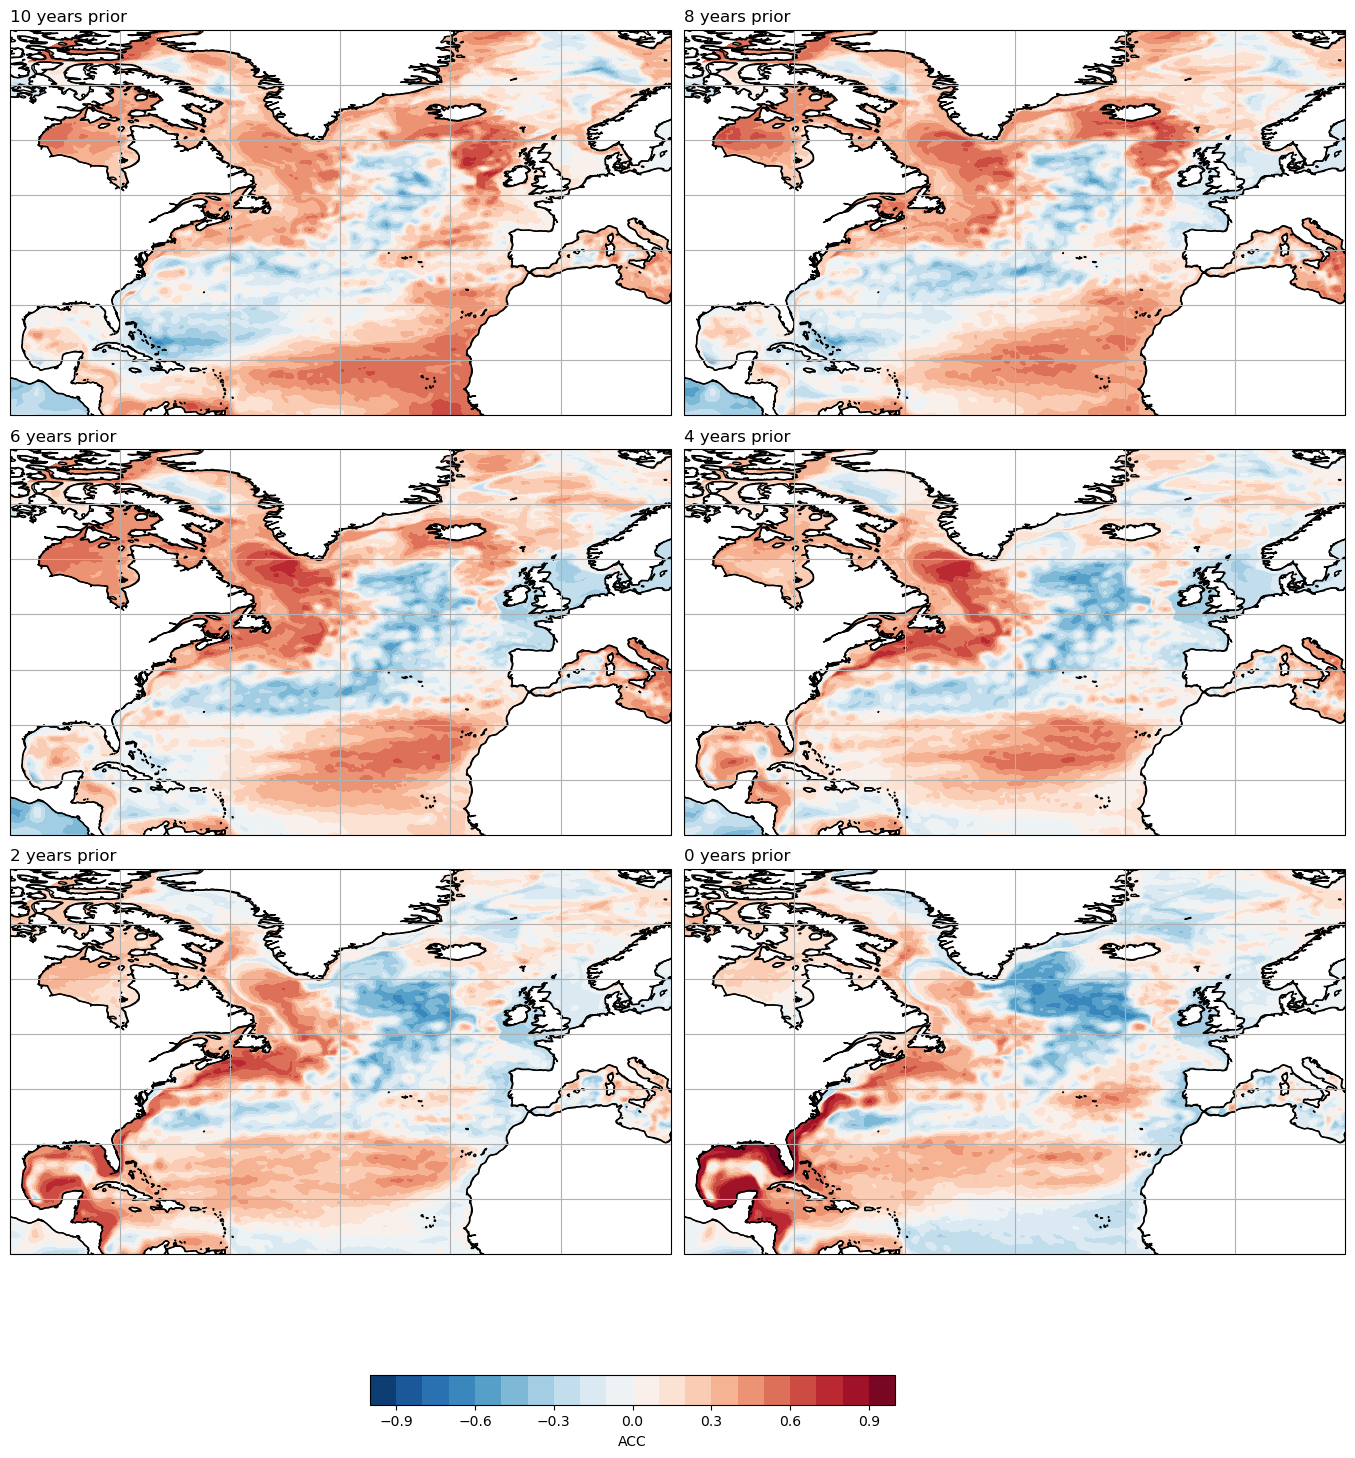

In [56]:
fontsize=12
colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
fig = plt.figure(figsize=(15, 15))
nrow = 3
ncol = 2
nplot = nrow*ncol

corrlevs = np.arange(0,21,1)*0.1 - 1

for i in range(nplot):
    ax = fig.add_subplot(nrow, ncol, i+1, projection=proj1)
    thislag = -6+i*2
    tmp = ssh_reg_moc26.sel(lag=thislag).sel(stat='corr')
    cntr = ax.contourf(hr_lon, hr_lat, tmp, levels=corrlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='neither')
    ax.coastlines(resolution='50m')
    ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
    ax.set_title('{} years prior'.format(-thislag),fontsize=fontsize, loc='left')
    ax.coastlines()
    extent = [-100,20, 10, 80]
    ax.set_extent(extent,crs=ccrs.PlateCarree())

fig.tight_layout()
fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax = fig.add_axes([0.25, 0.06, 0.35, 0.02])
fig.colorbar(cntr, cax=cbar_ax, orientation='horizontal',label='ACC')

plt.savefig('PIcntrl_SSH_regress_MOC26.png')